### Part 2: Poetry generation (for real)

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
# import string
# import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
# if not os.path.exists('sonnets.txt'):
#     !wget https://github.com/girafe-ai/ml-course/blob/24f_mipt/homeworks/lab03_deep_learning/sonnets.txt

# with open('sonnets.txt', 'r') as iofile:
#     text = iofile.readlines()

# TEXT_START = 45
# TEXT_END = -368
# text = text[TEXT_START : TEXT_END]
# print(len(text))
# assert len(text) == 2616                 не проходит, буду использовать текст Евгенгия Онегина

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# assert len(text) == 100225, "Are you sure you have concatenated all the strings?"
# assert not any([x in set(text) for x in string.ascii_uppercase]), "Uppercase letters are present"
# print("OK!")

### Data loading: "Евгений Онегин"


In [4]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = [x.replace('\t\t', '') for x in text]

--2024-12-12 19:49:46--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-12-12 19:49:47 (9.69 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

out = ''.join(text).lower()


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(out)) + ['<sos>']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here

import torch

token_to_id = {char: i for i, char in enumerate(tokens)}
id_to_token = {i: char for i, char in enumerate(tokens)}

torch.serialization.add_safe_globals(token_to_id)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

(у Пушкина больше токенов)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
import numpy as np
import torch
import torch.nn as nn


def generate_batch(text_encoded, batch_size, seq_length=100):
    start_column = np.zeros((batch_size, 1), dtype=int) + token_to_id['<sos>']
    max_start_index = max(0, len(text_encoded) - batch_size * seq_length - 1)
    start_index = np.random.randint(0, max_start_index + 1)
    data = np.array(text_encoded[start_index:start_index + batch_size * seq_length]).reshape((batch_size, -1))

    yield np.hstack((start_column, data))

def train_model(model, train_text, num_epochs=100, batch_size=1000, lr=0.001, seq_length=20):
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    loss_history = []

    for epoch in range(1, num_epochs + 1):
        loss = 0

        batch = next(generate_batch(train_text, batch_size, seq_length))
        input_sequence = torch.tensor(batch[:, :-1], dtype=torch.int64)
        target_sequence = torch.tensor(batch[:, 1:], dtype=torch.int64)
        hidden_state = model.initial_state(batch_size)

        optimizer.zero_grad()


        for i in range(seq_length):
            target = target_sequence[:, i]

            out, hidden_state = model(input_sequence[:, i], hidden_state)
            loss += loss_function(out, target)

        loss /= seq_length
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 50 == 0:
            print(f'Epoch: {epoch}/{num_epochs}, loss: {loss}')

    print(f'result loss: {loss.item()}')

    plt.plot(range(1, num_epochs + 1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Function over Epochs')
    plt.grid(True)
    plt.show()

    return loss_history

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class VanillaRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, embed_size = 128):
        super().__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(input_size, embed_size)
        self.hidden = nn.Linear(embed_size + hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

    def forward(self, input, hidden):
        input = self.embed(input)
        combined = torch.cat((input, hidden), dim=1)
        hidden = self.activation(self.hidden(combined))
        output = self.output(hidden)
        return output, hidden

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

Epoch: 50/1000, loss: 2.6512508392333984
Epoch: 100/1000, loss: 2.4831459522247314
Epoch: 150/1000, loss: 2.366734027862549
Epoch: 200/1000, loss: 2.288707733154297
Epoch: 250/1000, loss: 2.2114577293395996
Epoch: 300/1000, loss: 2.230729103088379
Epoch: 350/1000, loss: 2.139805793762207
Epoch: 400/1000, loss: 2.0920348167419434
Epoch: 450/1000, loss: 2.047820568084717
Epoch: 500/1000, loss: 2.048295497894287
Epoch: 550/1000, loss: 2.0265603065490723
Epoch: 600/1000, loss: 1.9436442852020264
Epoch: 650/1000, loss: 1.9391311407089233
Epoch: 700/1000, loss: 1.9057025909423828
Epoch: 750/1000, loss: 1.8755791187286377
Epoch: 800/1000, loss: 1.9502284526824951
Epoch: 850/1000, loss: 1.8888047933578491
Epoch: 900/1000, loss: 1.9110558032989502
Epoch: 950/1000, loss: 1.9023597240447998
Epoch: 1000/1000, loss: 1.8104932308197021
result loss: 1.8104932308197021


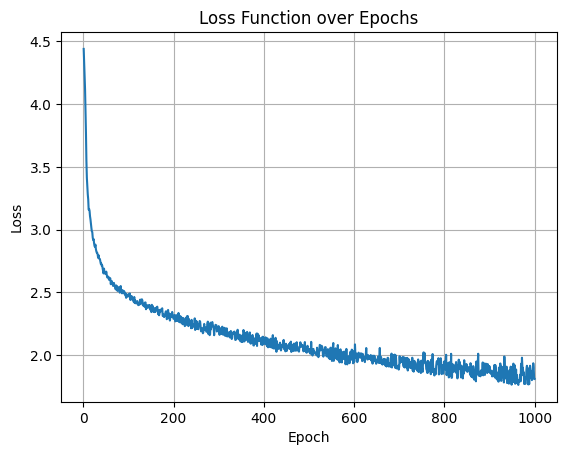

In [10]:
input_size = len(tokens)
output_size = len(tokens)

text_encoded = [token_to_id[token] for token in out]

vanilla = VanillaRNN(input_size, output_size)

vanilla_train_history = train_model(vanilla, text_encoded, num_epochs=1000)

In [11]:
import torch.nn.functional as F
import numpy as np


def generate_sample(char_rnn, seed_phrase, max_length=100, temperature=1.0):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    for i in range(len(seed_phrase) - 1):
        input_tensor = x_sequence[:, i]
        out, hid_state = char_rnn(input_tensor, hid_state)

    for _ in range(max_length - len(seed_phrase)):
        input_tensor = x_sequence[:, -1]
        out, hid_state = char_rnn(input_tensor, hid_state)

        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [12]:
# An example of generated text.
vanilla.eval()
print(generate_sample(vanilla, seed_phrase="хелло ворлд", max_length=300, temperature=0.4))

хелло ворлдела она грустный простоковет.



xix

и на получиться в самой друг,
гостельной думать волненье
на столы девицы признаться не спит.



vii

но что ж онегина полушенный,
и в сени,
и на стала привется волненье глупой и подведь родная,
с долже красной свой полной коловой,
и стал не всё одно п


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

*Comment: if you wish, you can use small GPT as well (e.g. from https://github.com/karpathy/nanoGPT)*

Plot the loss function of the number of epochs. Does the final loss become better?

In [13]:
def train_lstm_model(model, train_text, num_epochs=100, batch_size=1000, lr=0.001, seq_length=20):
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_history = []

    for epoch in range(1, num_epochs + 1):
        loss = 0

        batch = next(generate_batch(train_text, batch_size, seq_length))
        input_sequence = torch.tensor(batch[:, :-1], dtype=torch.int64)
        target_sequence = torch.tensor(batch[:, 1:], dtype=torch.int64)
        hidden_state = model.initial_state(batch_size)

        optimizer.zero_grad()

        for i in range(seq_length):
            target = target_sequence[:, i]
            out, hidden_state = model(input_sequence[:, i], hidden_state)
            loss += loss_function(out, target)

        loss /= seq_length
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

        if epoch % 50 == 0:
            print(f'Epoch: {epoch}/{num_epochs}, loss: {loss}')


    print(f'result loss: {loss.item()}')

    plt.plot(range(1, num_epochs + 1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Function over Epochs')
    plt.grid(True)
    plt.show()

    return loss_history

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=256, embed_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        self.embed = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers = 2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.embed(input)
        input = input.unsqueeze(0)
        out, hidden = self.lstm(input, hidden)
        out = self.fc(out[0])
        return out, hidden

    def initial_state(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size),
                torch.zeros(2, batch_size, self.hidden_size))

Epoch: 50/1000, loss: 3.074888229370117
Epoch: 100/1000, loss: 2.637885332107544
Epoch: 150/1000, loss: 2.46692156791687
Epoch: 200/1000, loss: 2.400540351867676
Epoch: 250/1000, loss: 2.300961971282959
Epoch: 300/1000, loss: 2.268559455871582
Epoch: 350/1000, loss: 2.1648333072662354
Epoch: 400/1000, loss: 2.1450743675231934
Epoch: 450/1000, loss: 2.012503147125244
Epoch: 500/1000, loss: 2.0887820720672607
Epoch: 550/1000, loss: 1.9123141765594482
Epoch: 600/1000, loss: 1.9980653524398804
Epoch: 650/1000, loss: 1.9646152257919312
Epoch: 700/1000, loss: 1.8770122528076172
Epoch: 750/1000, loss: 1.8777459859848022
Epoch: 800/1000, loss: 1.8552370071411133
Epoch: 850/1000, loss: 1.842430830001831
Epoch: 900/1000, loss: 1.7291326522827148
Epoch: 950/1000, loss: 1.694521188735962
Epoch: 1000/1000, loss: 1.7444149255752563
result loss: 1.7444149255752563


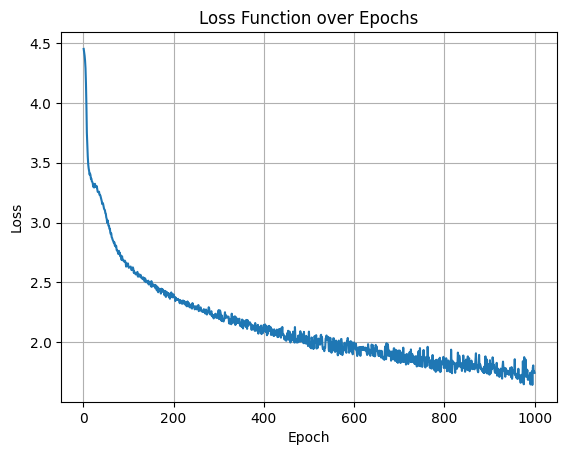

In [15]:
lstm_model = LSTMModel(input_size, output_size)

lstm_train_history = train_lstm_model(lstm_model, text_encoded, num_epochs=1000)


Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [16]:
def generate_sample_lstm(lstm_model, seed_phrase, max_length=100, temperature=1.0):
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = lstm_model.initial_state(batch_size=1)

    for i in range(len(seed_phrase) - 1):
        input_tensor = x_sequence[:, i]
        out, hid_state = lstm_model(input_tensor, hid_state)

    for _ in range(max_length - len(seed_phrase)):
        input_tensor = x_sequence[:, -1]
        out, hid_state = lstm_model(input_tensor, hid_state)

        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return "".join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [17]:
lstm_model.eval()
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"Temperature: {temperature}\n" + generate_sample_lstm(lstm_model, seed_phrase="кто я", max_length=100, temperature=temperature) + "\n\n")


Temperature: 0.1
кто я то сказать верен,
в сердце не видит с ним она в семье в соседстве не полон
в соседстве не поло


Temperature: 0.2
кто я скоро свете в том полова
и привычка приведанья,
в сей не скучно в том просто в соседстве сердц


Temperature: 0.5
кто я так на волненья.
благословил он простойный взор.



xxvii

как как диня с ним в самом получил 


Temperature: 1.0
кто я, можут в кусти, как с них город
запершись я нас лие кровь;
но разной задумчивает –ся ольги слы


Temperature: 2.0
кто я?», очень амантсных ниш.
«лыги пос]-солочеk шаееков…
вpяii:

квой остяк:ынтавяю
взвездная ремян




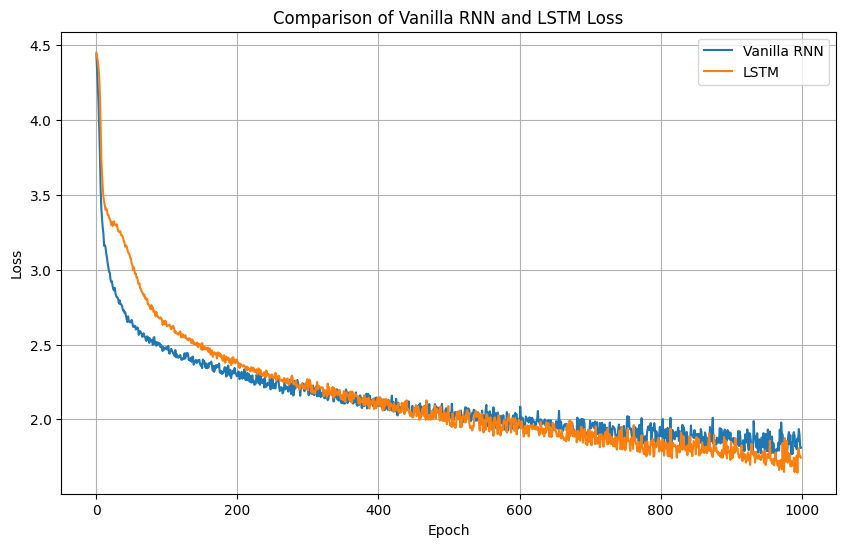

In [18]:
# сравнение историй обучения vanilla и lstm
plt.figure(figsize=(10, 6))
plt.plot(vanilla_train_history, label='Vanilla RNN')
plt.plot(lstm_train_history, label='LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Comparison of Vanilla RNN and LSTM Loss')
plt.legend()
plt.grid(True)
plt.show()

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [19]:
torch.save(vanilla.state_dict(), 'vanilla_model.pth')

loaded_vanilla_model = VanillaRNN(input_size, output_size)
loaded_vanilla_model.load_state_dict(torch.load('vanilla_model.pth',  weights_only=True))
loaded_vanilla_model.eval()


print(generate_sample(loaded_vanilla_model, seed_phrase='хахаха', max_length=500, temperature=0.25))

хахаха
в самой души молвилась в сображенье
татьяна в семье тотках долго в нем на простой одна привычка в семья приности моей волненье страшно уж на полно отворилась в собранилась татьяна в сосед не было страшно в сердце привычный своей девицы друг был постельной пустокрыться, как в старине,
в отцарей полодной
и в сердце встала с собой
она полно, не скоро старины сердце в очей
приятный вздохнулась,
под ним под ней
и в сада беспечно, не слушало,
и на был подобный полной полной меревне разговор,
и 


In [20]:
torch.save(lstm_model.state_dict(), 'lstm_model.pth')

loaded_lstm_model = LSTMModel(input_size, output_size)
loaded_lstm_model.load_state_dict(torch.load('lstm_model.pth',  weights_only=True))
loaded_lstm_model.eval()


print(generate_sample_lstm(loaded_lstm_model, seed_phrase='хахаха', max_length= 500, temperature=0.25))

хахахать,
и славы страстей в постеле в том больше не забыть,
и в садость небо всех в санях сей невольно досада
и в судьбу привычка стольмо не знала по том отрада,
и в деревне в семья развелась она в сердце не видит,
и странен и вот она в санях сей просторой
признаться делать полова, по сказал он за станой
старика старый свой волненья,
под ней он все возврать она в семье встали в самом полуманной
старины светский встав в том полова,
как на своей порок и слез и в самом полове странный
она в тишине


**Не получилось сгенерировать что-то осознанное, некоторые слова выдуманные, но некоторые строки даже рифмуются(не по стихотворному размеру, но по окончанию). Более долгое обучение в среднем может немного уменьшить loss, но обучение тогда будет занимать больше времени, и, вероятно, приведет к переобучению, так как дропаутов и других мредств борьбы с переобучением не использовалось.**

Epoch: 50/1000, loss: 1.7281081676483154
Epoch: 100/1000, loss: 1.8664602041244507
Epoch: 150/1000, loss: 1.7561626434326172
Epoch: 200/1000, loss: 1.716027021408081
Epoch: 250/1000, loss: 1.6111438274383545
Epoch: 300/1000, loss: 1.647205114364624
Epoch: 350/1000, loss: 1.6059820652008057
Epoch: 400/1000, loss: 1.5624525547027588
Epoch: 450/1000, loss: 1.5448585748672485
Epoch: 500/1000, loss: 1.5277572870254517
Epoch: 550/1000, loss: 1.6497628688812256
Epoch: 600/1000, loss: 1.6383317708969116
Epoch: 650/1000, loss: 1.7283742427825928
Epoch: 700/1000, loss: 1.457663893699646
Epoch: 750/1000, loss: 1.4730641841888428
Epoch: 800/1000, loss: 1.4406492710113525
Epoch: 850/1000, loss: 1.3902482986450195
Epoch: 900/1000, loss: 1.363269567489624
Epoch: 950/1000, loss: 1.6222463846206665
Epoch: 1000/1000, loss: 1.3359005451202393
result loss: 1.3359005451202393


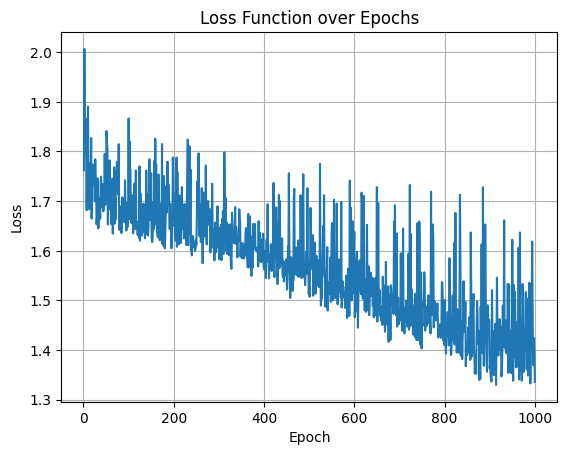

In [21]:
lstm_model.train()
lstm_train_history += train_lstm_model(lstm_model, text_encoded, num_epochs=1000)

Epoch: 50/1000, loss: 1.3735017776489258
Epoch: 100/1000, loss: 1.3186991214752197
Epoch: 150/1000, loss: 1.323996901512146
Epoch: 200/1000, loss: 1.3416728973388672
Epoch: 250/1000, loss: 1.3509585857391357
Epoch: 300/1000, loss: 1.3049236536026
Epoch: 350/1000, loss: 1.6011508703231812
Epoch: 400/1000, loss: 1.2358132600784302
Epoch: 450/1000, loss: 1.2575080394744873
Epoch: 500/1000, loss: 1.2596920728683472
Epoch: 550/1000, loss: 1.2442694902420044
Epoch: 600/1000, loss: 1.3027770519256592
Epoch: 650/1000, loss: 1.3669250011444092
Epoch: 700/1000, loss: 1.2302968502044678
Epoch: 750/1000, loss: 1.202599048614502
Epoch: 800/1000, loss: 1.153021216392517
Epoch: 850/1000, loss: 1.1702125072479248
Epoch: 900/1000, loss: 1.1380428075790405
Epoch: 950/1000, loss: 1.4054296016693115
Epoch: 1000/1000, loss: 1.141221523284912
result loss: 1.141221523284912


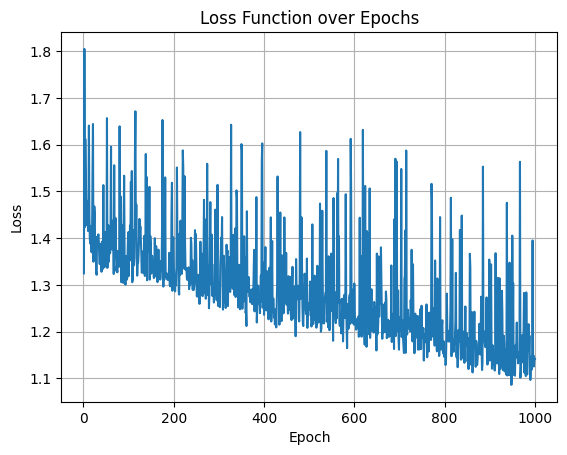

In [22]:
lstm_train_history += train_lstm_model(lstm_model, text_encoded, num_epochs=1000)

Epoch: 50/1000, loss: 1.1486046314239502
Epoch: 100/1000, loss: 1.0807772874832153
Epoch: 150/1000, loss: 1.0756765604019165
Epoch: 200/1000, loss: 1.0611706972122192
Epoch: 250/1000, loss: 1.3213595151901245
Epoch: 300/1000, loss: 1.1358559131622314
Epoch: 350/1000, loss: 1.0692267417907715
Epoch: 400/1000, loss: 1.3546416759490967
Epoch: 450/1000, loss: 1.1072721481323242
Epoch: 500/1000, loss: 1.0723179578781128
Epoch: 550/1000, loss: 1.0982718467712402
Epoch: 600/1000, loss: 1.0716198682785034
Epoch: 650/1000, loss: 1.0891798734664917
Epoch: 700/1000, loss: 1.3355547189712524
Epoch: 750/1000, loss: 1.1583597660064697
Epoch: 800/1000, loss: 1.0769579410552979
Epoch: 850/1000, loss: 1.1096551418304443
Epoch: 900/1000, loss: 1.0775986909866333
Epoch: 950/1000, loss: 1.0834914445877075
Epoch: 1000/1000, loss: 1.1203418970108032
result loss: 1.1203418970108032


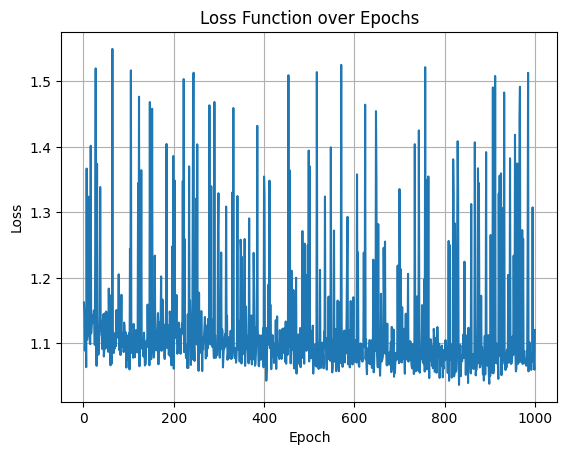

In [23]:
lstm_train_history += train_lstm_model(lstm_model, text_encoded, num_epochs=1000, lr=0.0001)

Epoch: 50/1000, loss: 1.0778790712356567
Epoch: 100/1000, loss: 1.0880173444747925
Epoch: 150/1000, loss: 1.0445009469985962
Epoch: 200/1000, loss: 1.0957672595977783
Epoch: 250/1000, loss: 1.0619124174118042
Epoch: 300/1000, loss: 1.058582067489624
Epoch: 350/1000, loss: 1.0740816593170166
Epoch: 400/1000, loss: 1.070243239402771
Epoch: 450/1000, loss: 1.428764820098877
Epoch: 500/1000, loss: 1.049773097038269
Epoch: 550/1000, loss: 1.0765526294708252
Epoch: 600/1000, loss: 1.0551670789718628
Epoch: 650/1000, loss: 1.0931737422943115
Epoch: 700/1000, loss: 1.0558615922927856
Epoch: 750/1000, loss: 1.049802541732788
Epoch: 800/1000, loss: 1.4405715465545654
Epoch: 850/1000, loss: 1.0417453050613403
Epoch: 900/1000, loss: 1.0843901634216309
Epoch: 950/1000, loss: 1.0357648134231567
Epoch: 1000/1000, loss: 1.0566906929016113
result loss: 1.0566906929016113


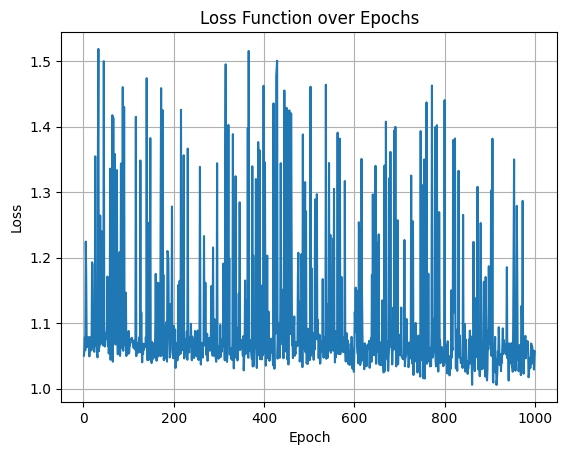

In [24]:
lstm_train_history += train_lstm_model(lstm_model, text_encoded, num_epochs=1000, lr=0.0001)

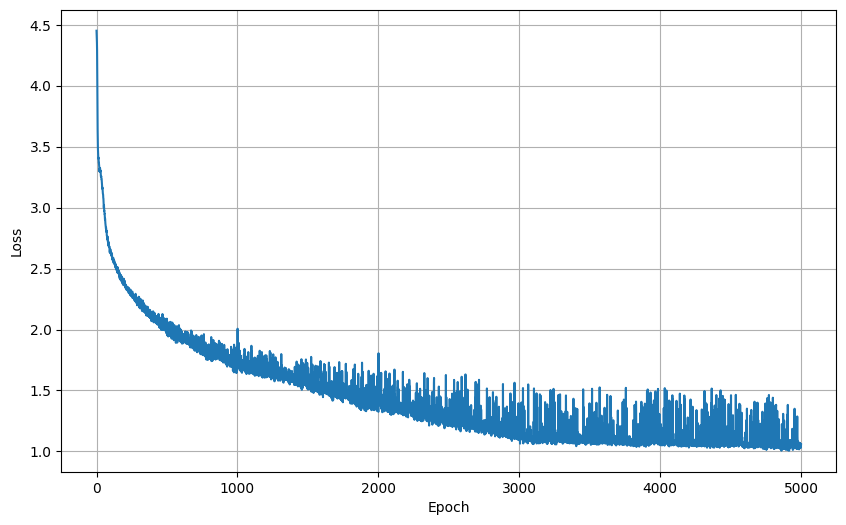

In [25]:
# полная история

plt.figure(figsize=(10, 6))
plt.plot(lstm_train_history, label='LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

In [26]:
lstm_model.eval()
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print(f"Temperature: {temperature}\n" + generate_sample_lstm(lstm_model, seed_phrase="бубубубу", max_length=500, temperature=temperature) + "\n\n")

Temperature: 0.1
бубубубу час оставить.
да стол подвинь, я отстал нам одна
не обез и никовые
наут, иль ответа,
в сем 


Temperature: 0.2
бубубубу час оставить.
да стол подвинь, поклоны,
глава шестая



xxxiii

приди в тарине страсти ей и


Temperature: 0.5
бубубубу час оставить.
живу, за стол садясь,
пролюбовник матери, брила ли? но не тут
и тайных снова,


Temperature: 1.0
бубубубу)
как он синей бродит, к перевелопоткрытом взглядом хлобователь свой пистолет.



liii

шум,


Temperature: 2.0
бубубубу
запытшекли зовет
произняет таню ларина! уж по твющупречию,
слезий этандцами
браном бились ж




модель слегка переобучилась, начала цитировать Евгения Онегина при небольшой температуре

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)
4. nanoGPT by Andrej Karpathy: https://github.com/karpathy/nanoGPT